In [86]:
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer.noise import depolarizing_error


%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True
rc('text', usetex=True)
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [70]:
token = 'enter your token'
try:
    IBMQ.load_account()
except:
    qk.IBMQ.save_account(token=token)
    qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")

ibmqfactory.load_account:WARNING:2022-02-10 11:00:14,935: Credentials are already in use. The existing account in the session will be replaced.


In [71]:
device = 'choose a device!'
device_backend = provider.get_backend(device)

In [72]:
sim_backend = qk.Aer.get_backend('qasm_simulator')

In [73]:
num_qubits = 1  # Number of qubits
qr = qk.QuantumRegister(num_qubits) # Define quantum register
cr = qk.ClassicalRegister(num_qubits) # Define classical register


theta = np.pi/2
def identity_evolve_meas_rx(num_idens):
    circ = qk.QuantumCircuit(qr, cr) # Define base quantum circuit
    circ.ry(theta, qr[0]) # Applying an Ry(theta) gate to the zeroth qubit in the register
    [circ.i(qr[0]) for _ in range(num_idens)] # Apply a series of identities to let the qubit evolve freely
    circ.h( qr[0]) # Rotate qubit to measure in the y basis
    circ.measure(qr[0],cr[0])
    return circ

def identity_evolve_meas_ry(num_idens):
    circ = qk.QuantumCircuit(qr, cr) # Define base quantum circuit
    circ.ry(theta, qr[0]) # Applying an Ry(theta) gate to the zeroth qubit in the register
    [circ.i(qr[0]) for _ in range(num_idens)]  # Apply a series of identities to let the qubit evolve freely
    circ.sdg(qr[0]) # Rotate qubit to measure in the y basis
    circ.h(qr[0]) # Rotate qubit to measure in the y basis
    circ.measure(qr[0],cr[0])
    return circ

def identity_evolve_meas_rz(num_idens):
    circ = qk.QuantumCircuit(qr, cr) # Define base quantum circuit
    circ.ry(theta, qr[0]) # Applying an Ry(theta) gate to the zeroth qubit in the register
    [circ.i(qr[0]) for _ in range(num_idens)] # Apply a series of identities to let the qubit evolve freely
    circ.measure(qr[0],cr[0]) 
    return circ

In [74]:
# Build a list of all circuits
circ_list = {}
for num_idens in range(1,8000,100):
    circ_list['N%d_rx' % num_idens] = identity_evolve_meas_rx(num_idens)
    circ_list['N%d_ry' % num_idens] = identity_evolve_meas_ry(num_idens)
    circ_list['N%d_rz' % num_idens] = identity_evolve_meas_rz(num_idens)

# Depolarizing Noise Simulation

In [101]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit gates
p = 0.001 # probability of depolarization
error = depolarizing_error(p, 1)
noise_model.add_all_qubit_quantum_error(error, ['id', 'sx', 'x'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u3', 'x']
  Instructions with noise: ['x', 'sx', 'id']
  All-qubits errors: ['id', 'sx', 'x']


In [102]:
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

shots = 1000

depol_job = qk.execute(list(circ_list.values()), backend=sim_backend, shots=shots,
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model, optimization_level=0) # Execute job

C:\Users\quirogd1\AppData\Local\Continuum\anaconda3\envs\strat_ed_Fall2021\lib\site-packages\qiskit\providers\aer\aerjob.py:55: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


In [104]:
depol_result = depol_job.result() # Collect results
depol_results_list = {}
for key in circ_list.keys():
    circ = circ_list[key]
    counts = depol_result.get_counts(circ)
    depol_results_list[key] = (counts['0'] - counts.get('1',0))/shots # calculate expectation values

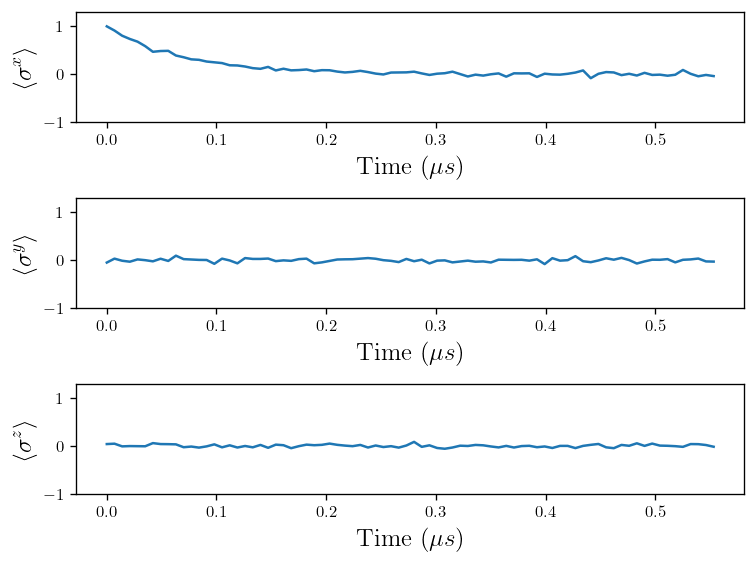

In [109]:
t_id = 70e-9*1e3 # us

rez_rx = []
rez_ry = []
rez_rz = []
for num_idens in range(1,8000,100):
    rez_rx.append([num_idens*t_id, depol_results_list['N%d_rx' % num_idens]])
    rez_ry.append([num_idens*t_id, depol_results_list['N%d_ry' % num_idens]])
    rez_rz.append([num_idens*t_id, depol_results_list['N%d_rz' % num_idens]])
    
rez_rx = np.array(rez_rx)
rez_ry = np.array(rez_ry)
rez_rz = np.array(rez_rz)

rez_list = [rez_rx, rez_ry, rez_rz]
labels = [r'$\langle \sigma^x \rangle$', r'$\langle \sigma^y \rangle$', r'$\langle \sigma^z \rangle$']

fig = plt.figure(dpi=120)
for idx, rez in enumerate(rez_list):
    ax = fig.add_subplot(3,1,idx+1)
    ax.plot(rez[:,0], rez[:,1])
    ax.set_ylim([-1,1.3])
    ax.set_xlabel(r'Time ($\mu s$)', fontsize=15)
    ax.set_ylabel(labels[idx], fontsize=15)
plt.tight_layout()

# Noisy Hardware Simulation

In [75]:
noise_model = NoiseModel.from_backend(device_backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [76]:
shots = 1000

job = qk.execute(list(circ_list.values()), backend=sim_backend, shots=shots,
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model, optimization_level=0) # Execute job

C:\Users\quirogd1\AppData\Local\Continuum\anaconda3\envs\strat_ed_Fall2021\lib\site-packages\qiskit\providers\aer\aerjob.py:55: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


In [77]:
result = job.result() # Collect results
results_list = {}
for key in circ_list.keys():
    circ = circ_list[key]
    counts = result.get_counts(circ)
    results_list[key] = (counts['0'] - counts['1'])/shots # calculate expectation values

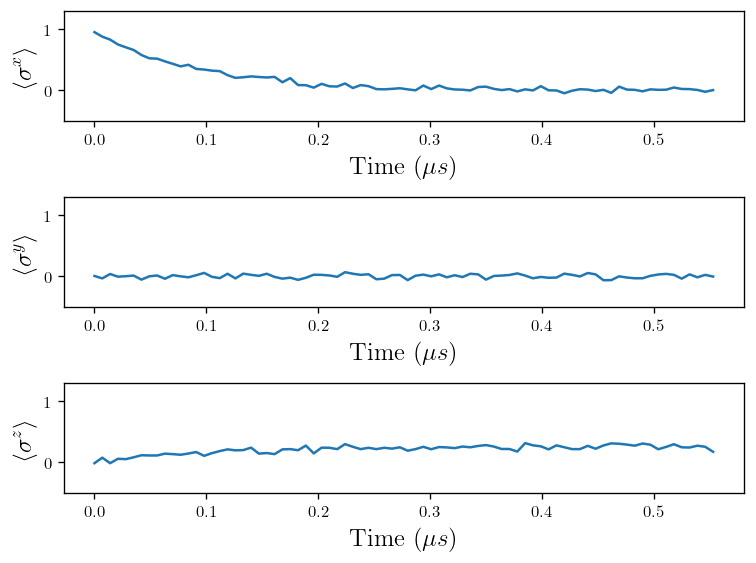

In [110]:
t_id = 35e-9*1e3 # typical identity gate time in microseconds

rez_rx = []
rez_ry = []
rez_rz = []
for num_idens in range(1,8000,100):
    rez_rx.append([num_idens*t_id, results_list['N%d_rx' % num_idens]])
    rez_ry.append([num_idens*t_id, results_list['N%d_ry' % num_idens]])
    rez_rz.append([num_idens*t_id, results_list['N%d_rz' % num_idens]])
    
rez_rx = np.array(rez_rx)
rez_ry = np.array(rez_ry)
rez_rz = np.array(rez_rz)

rez_list = [rez_rx, rez_ry, rez_rz]
labels = [r'$\langle \sigma^x \rangle$', r'$\langle \sigma^y \rangle$', r'$\langle \sigma^z \rangle$']

fig = plt.figure(dpi=120)
for idx, rez in enumerate(rez_list):
    ax = fig.add_subplot(3,1,idx+1)
    ax.plot(rez[:,0], rez[:,1])
    ax.set_ylim([-0.5,1.3])
    ax.set_xlabel(r'Time ($\mu s$)', fontsize=15)
    ax.set_ylabel(labels[idx], fontsize=15)
plt.tight_layout()

# Comparison with Hardware

In [114]:
shots = 1000

circs = qk.transpile(list(circ_list.values()), backend=device_backend, optimization_level=0)

job_manager = IBMQJobManager()
job_set = job_manager.run(circs, backend=device_backend, name='depol', shots=shots)

In [116]:
job_set.statuses()

[<JobStatus.DONE: 'job has successfully run'>]

In [117]:
hardware_results = job_set.results() 
hw_results_list = {}
for key in circ_list.keys():
    circ = circ_list[key]
    counts = hardware_results.get_counts(circ)
    hw_results_list[key] = (counts['0'] - counts['1'])/shots # calculate expectation values

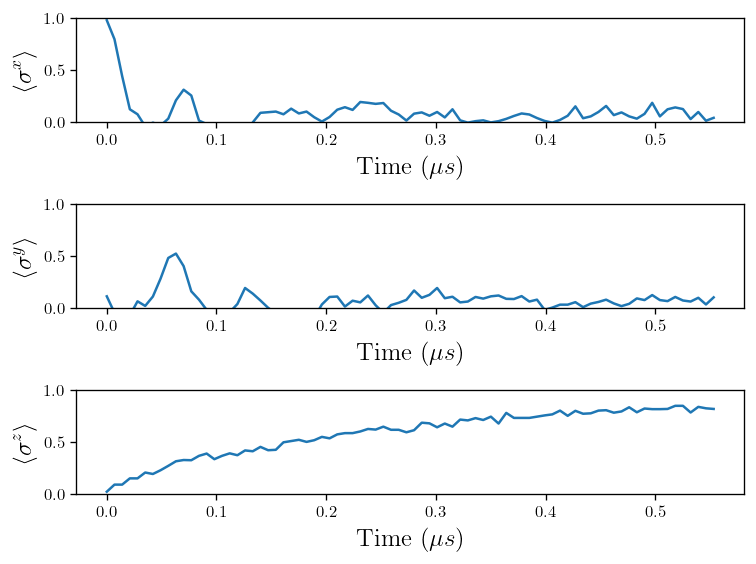

In [118]:
t_id = 70e-9*1e3 # us

rez_rx = []
rez_ry = []
rez_rz = []
for num_idens in range(1,8000,100):
    rez_rx.append([num_idens*t_id, hw_results_list['N%d_rx' % num_idens]])
    rez_ry.append([num_idens*t_id, hw_results_list['N%d_ry' % num_idens]])
    rez_rz.append([num_idens*t_id, hw_results_list['N%d_rz' % num_idens]])
    
rez_rx = np.array(rez_rx)
rez_ry = np.array(rez_ry)
rez_rz = np.array(rez_rz)

rez_list = [rez_rx, rez_ry, rez_rz]
labels = [r'$\langle \sigma^x \rangle$', r'$\langle \sigma^y \rangle$', r'$\langle \sigma^z \rangle$']

fig = plt.figure(dpi=120)
for idx, rez in enumerate(rez_list):
    ax = fig.add_subplot(3,1,idx+1)
    ax.plot(rez[:,0], rez[:,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(r'Time ($\mu s$)', fontsize=15)
    ax.set_ylabel(labels[idx], fontsize=15)
plt.tight_layout()